# <center><b> Práctica 2 de Laboratorio 5 </b><br><u> Espectroscopía Láser </u></center>

Grupo 1: Trinidad Borrel, Bruno Sivilotti, Agustín Brusco

In [1]:
import pyvisa as visa
import numpy as np
import matplotlib.pyplot as plt
# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'
rcParams['axes.xmargin'] = 0
rcParams['axes.grid'] = True

# Formato para los gráficos:
MARKER_FMT = dict(markersize=6, markeredgewidth=0.25, markeredgecolor='k',)
ERROR_FMT = dict(ecolor='k', capsize=2,)

from instrumental import TDS1002B
try:
    rm.close()
except NameError:
    pass
rm = visa.ResourceManager()

instruments = rm.list_resources()
print(instruments)

for inst in instruments:
    if 'C102220::0::INSTR' in inst:  # Ojo si nos cambian el osciloscopio
        print('Osciloscopio TDS1002B detectado:',
            f'\nID: {inst}')
        osci = TDS1002B(inst)
        
    elif 'M00404166::0::INSTR' in inst:
        print('Laser Diode Temperature Controller detectado:',
            f'\nID: {inst}')

('USB0::1689::867::C102220::0::INSTR',)
Osciloscopio TDS1002B detectado: 
ID: USB0::1689::867::C102220::0::INSTR
TEKTRONIX,TDS 1002B,C102220,CF:91.1CT FV:v22.11



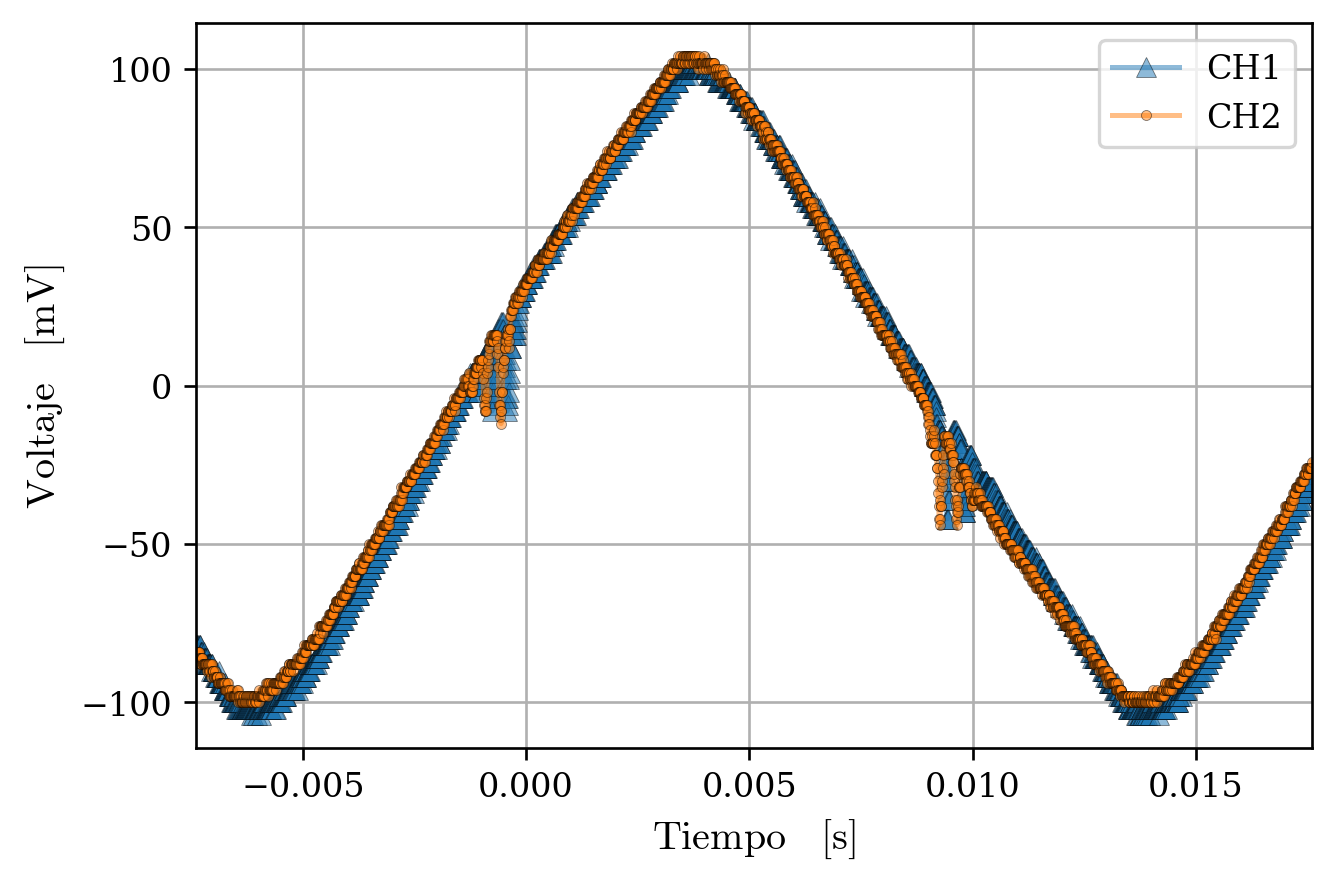

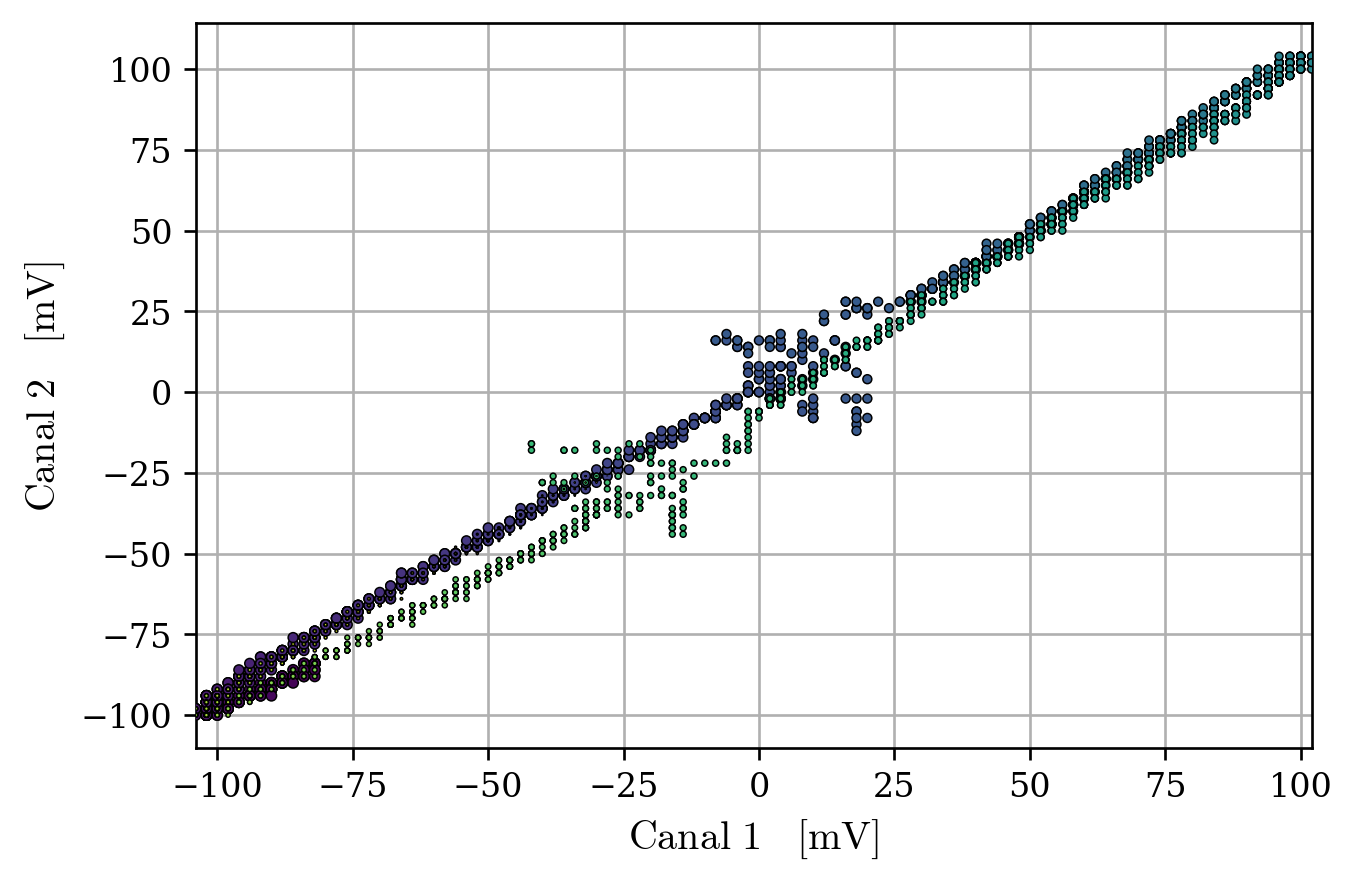

In [55]:
volt_scale = 'mV'
scale_dict = {'V': 1e0, 'mV': 1e3,}

tiempo, channel1 = osci.read_data(0)  # s, V
tiempo, channel2 = osci.read_data(1)  # s, V


plt.figure()
plt.plot(tiempo, channel1*scale_dict[volt_scale], '^-',
         **MARKER_FMT, alpha=0.5, label='CH1')
plt.plot(tiempo, channel2*scale_dict[volt_scale], '.-',
         **MARKER_FMT, alpha=0.5, label='CH2')
plt.legend()
plt.xlabel('$\mathrm{Tiempo}\quad\mathrm{[s]}$')
plt.ylabel('$\mathrm{Voltaje}\quad\mathrm{['+volt_scale+']}$')
plt.show()

plt.figure()
plt.scatter(channel1*scale_dict[volt_scale],
            channel2*scale_dict[volt_scale],
            s=7*(1 - tiempo/tiempo[-1]), c=tiempo,
            linewidths=0.45, edgecolors='k', zorder=10)
plt.xlabel('$\mathrm{Canal\ 1}\quad\mathrm{['+volt_scale+']}$')
plt.ylabel('$\mathrm{Canal\ 2}\quad\mathrm{['+volt_scale+']}$')
plt.show()

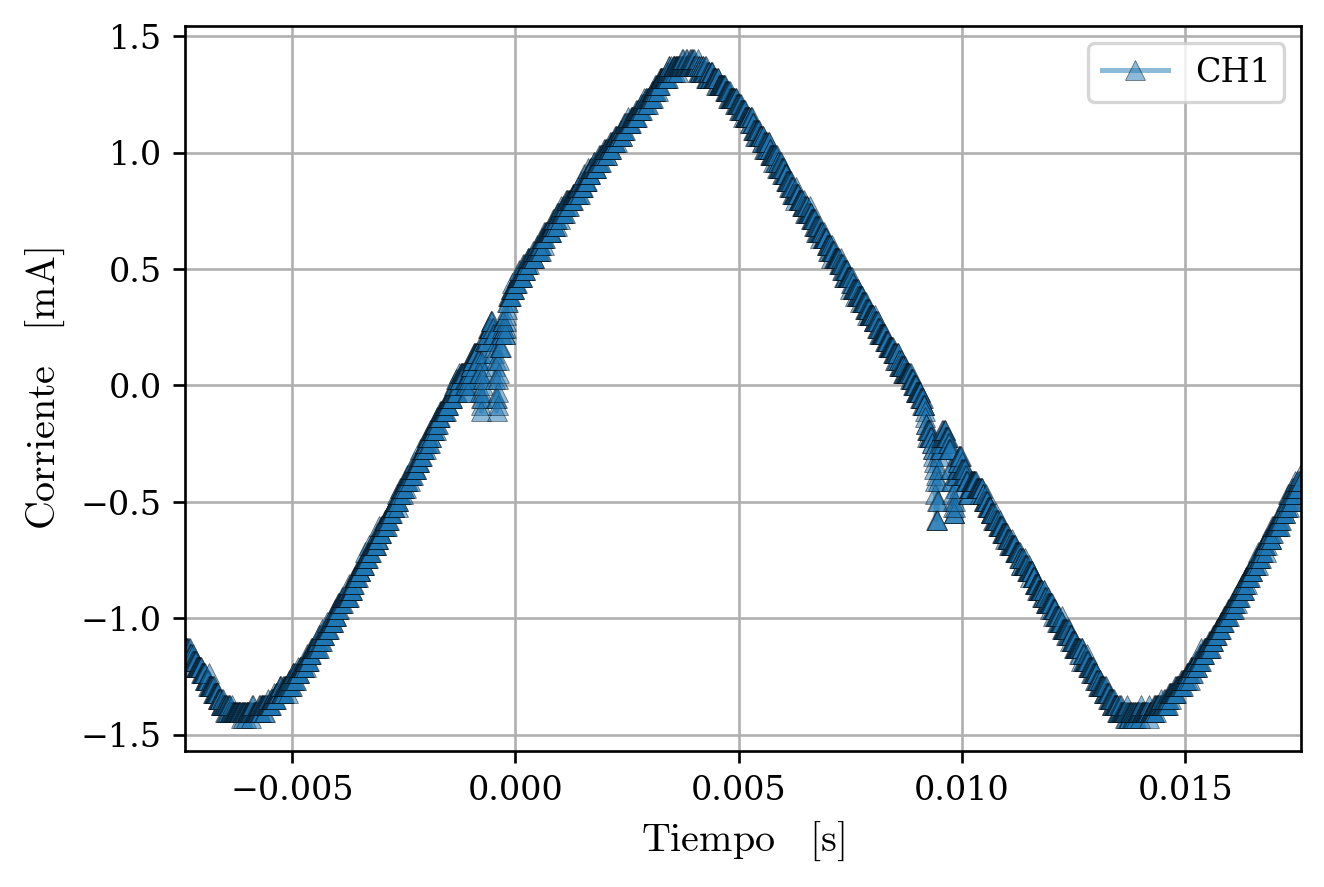

In [64]:
from scipy.signal import sawtooth
from scipy.optimize import curve_fit

def triangular(t, frecuencia, amplitud, fase, offset):
    return amplitud*sawtooth(t*frecuencia*2*np.pi + fase, width=0.5) + offset

amp_scale = 'mA'
scale_dict = {'V': 1e0, 'mV': 1e3, 'A': 1e0, 'mA': 1e3, }
popt, pcov = curve_fit(triangular, tiempo, channel1, p0=[50, 0.1, 0.7, 200])

# Hipotesis: los picos de tensión se asocian a los picos de corriente
corriente_setpoint = 1.4e-3  # A
corriente_depth = 0.1/100
corriente_max = corriente_setpoint*(1+corriente_depth)  # A
corriente_min = corriente_setpoint*(1-corriente_depth)  # A
Temperatura = 22.5  # °C : fija
corriente_rango = corriente_max - corriente_min  # A
voltaje_max = np.max(channel1)  # V
voltaje_min = np.min(channel1)  # V
voltaje_rango = voltaje_max - voltaje_min  # V
conversor = corriente_max/voltaje_max  # A/V

plt.figure()
plt.plot(tiempo, channel1*conversor*scale_dict[amp_scale], '^-',
         **MARKER_FMT, alpha=0.5, label='CH1')
# plt.plot(tiempo, channel2, '.-',
#          **MARKER_FMT, alpha=0.5, label='CH2')
# plt.plot(tiempo, triangular(tiempo, *popt))
plt.legend()
plt.xlabel('$\mathrm{Tiempo}\quad\mathrm{[s]}$')
plt.ylabel('$\mathrm{Corriente}\quad\mathrm{['+amp_scale+']}$')
plt.show()


In [62]:
corriente_max

0.0014014

## Save files:

Columnas: `tiempo [s], voltaje [V], voltaje [V]`

prueba0.npy y prueba1.npy : 
```
        corriente_setpoint = 1.4e-3  # A
        corriente_depth = 0.1/100
        Temperatura = 22.5  # °C : fija
```

In [54]:
def save_osci_data(t, *channels, filename=None):
    if filename is None:
        raise ValueError('Especificar `filename`.')
    osci_data = np.array([t, *channels],)
    np.save(filename, osci_data, )
    return None

filename = input('Filename: ')+'.npy'
save_osci_data(tiempo, channel1, channel2, filename=filename)

In [5]:
tiempo, channel1, channel2 = np.load('prueba0.npy')